In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.draw import polygon2mask
import cv2
import os
import string
import json
import networkx as nx
import copy
import pylab
pylab.rcParams['figure.figsize'] = (20,10)

In [2]:
COLORS = [
    [252, 15, 15], #Red
    [252, 165, 15], #orange
    [252, 232, 15], #yellow
    [14, 227, 39], #light green
    [10, 138, 37], # dark green
    [9, 219, 216], # light blue
    [9, 111, 219], # dark blue
    [185, 90, 232], # light purple
    [201, 40, 175], # purple
    [245, 49, 166] #pink
]


def get_mask_from_coco_ann(seg, image_shape):
    poly_xy = np.array(seg).reshape((int(len(seg) / 2), 2))
    poly_yx = np.zeros_like(poly_xy)
    poly_yx[:, 0], poly_yx[:, 1] = poly_xy[:, 1], poly_xy[:, 0]
    mask = polygon2mask(image_shape, poly_yx)
    return mask, poly_xy

def get_mid_top_loc(poly, image_h, image_w):
    top_idx = poly[:, 1].argmin()
    mid_top = (np.clip(int(poly[top_idx][0]), 15, image_w - 15),
               np.clip(int(poly[top_idx][1]), 15, image_h - 15))
    return mid_top


def fill_poly_with_list(I, polyfilled, poly_xy, c, alpha=0.6):
    polyfilled = cv2.fillPoly(polyfilled, pts=[poly_xy.reshape(-1, 1, 2).astype(np.int32)], color=c)
    I = cv2.addWeighted(I, alpha, polyfilled, 1 - alpha, 0)
    return I


def draw_polyline_with_list(I, poly_xy, c, isClosed=True, thickness=2):
    I = cv2.polylines(I, [poly_xy.reshape(-1, 1, 2).astype(np.int32)], isClosed, c, thickness)
    return I

def draw_graph_with_color(matrix, color_matrix, color='red', pos=None):
    edges = np.where(matrix == 1)

    from_idx = edges[0].tolist()
    to_idx = edges[1].tolist()

    from_node = [string.ascii_uppercase[i] for i in from_idx]
    to_node = [string.ascii_uppercase[i] for i in to_idx]

    G = nx.DiGraph()
    for i in range(matrix.shape[0]):
        G.add_node(string.ascii_uppercase[i])

    pos = nx.circular_layout(G)
    G.add_edges_from(list(zip(from_node, to_node)))
    colors_tf = [color_matrix[pair[0], pair[1]] for pair in list(zip(from_idx, to_idx))]
    edge_color = [color if color_tf else 'black' for color_tf in colors_tf]
    node_size=[600]*len(G)

    nx.draw_networkx_nodes(G, pos, node_size=node_size)
    nx.draw_networkx_labels(G, pos, font_color='w', font_size=15)
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, width=2, edge_color=edge_color)
    
    return pos

def write_text(img, text, location, c):
    cv2.rectangle(img, (location[0] - 5, location[1] - 10), (location[0] + 25, location[1] + 5), c, -1)
    cv2.putText(img, text, location, 0, 0.3, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)
    return img

def draw_occ_graph(occ_str_all, num_inst):
    occ_matrix = np.zeros((num_inst, num_inst)).astype(np.uint8)
    is_overlap_matrix = np.zeros((num_inst, num_inst)).astype(np.bool)
    for occ_str in occ_str_all:
        idx1, idx2 = occ_str['order'].split(' & ')[0].split('<')
        idx1, idx2 = int(idx1), int(idx2)
        if '&' in occ_str['order']: #bidirection
            occ_matrix[idx1, idx2] = 1
            occ_matrix[idx2, idx1] = 1
        else:
            occ_matrix[idx1, idx2] = 1
    draw_graph_with_color(occ_matrix, is_overlap_matrix, color='green')

def draw_depth_graph(depth_str_all, num_inst):
    depth_matrix = np.zeros((num_inst, num_inst)).astype(np.uint8)
    is_overlap_matrix = np.zeros((num_inst, num_inst)).astype(np.bool)
    for depth_str in InstaOrder_ann['depth']:
        if '=' in depth_str['order']:
            eq1_idx, eq2_idx = list(map(int,depth_str['order'].split('=')))

            depth_matrix[eq1_idx, eq2_idx] = 1
            depth_matrix[eq2_idx, eq1_idx] = 1
            is_overlap_matrix[eq1_idx, eq2_idx] = 1 if depth_str['overlap'] == True else 0
            is_overlap_matrix[eq2_idx, eq1_idx] = 1 if depth_str['overlap'] == True else 0
            
        elif '<' in depth_str['order']:
            near_idx, far_idx = list(map(int,depth_str['order'].split('<')))
            depth_matrix[near_idx, far_idx] = 1
            is_overlap_matrix[near_idx, far_idx] = 1 if depth_str['overlap'] == True else 0
    draw_graph_with_color(depth_matrix, is_overlap_matrix, color='green')

    
def draw_instance_mask(img, anns):
    mid_tops = []
    cat_names = []
    for i, ann in enumerate(anns):
        poly_xy_instance = []
        for seg_ind, seg in enumerate(ann['segmentation']):
            mask, poly_xy = get_mask_from_coco_ann(seg, image_shape=img.shape[:2])
            poly_xy_instance.append(poly_xy)  # [(n1,2), (n2,2), (n3,2)]

        # to putText
        cat_names.append(coco.loadCats(ann['category_id'])[0]['name'])

        mid_top = get_mid_top_loc(np.concatenate(poly_xy_instance), image_h, image_w)
        mid_tops.append(mid_top)

        # color every instance
        for poly_xy in poly_xy_instance:
            polyfilled = copy.deepcopy(img)
            img = fill_poly_with_list(img, polyfilled, poly_xy, COLORS[i], alpha=alpha)    
            img = draw_polyline_with_list(img, poly_xy, COLORS[i])

    for i in range(len(mid_tops)):
        text=string.ascii_uppercase[i]
        img = write_text(img, text, mid_tops[i], COLORS[i])
    return img

In [ ]:
base_dir = "../data" 
dataType = "val2017"
folder2save = f'../orders_png'
os.makedirs(folder2save, exist_ok=True)
alpha = 0.6

# read InstaOrder json
json_fname = f"{base_dir}/annotations/InstaOrder_{dataType}.json"
InstaOrder_data = json.load(open(json_fname))

# read COCO json
json_fname = f"{base_dir}/annotations/instances_{dataType}.json"
coco = COCO(json_fname)

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


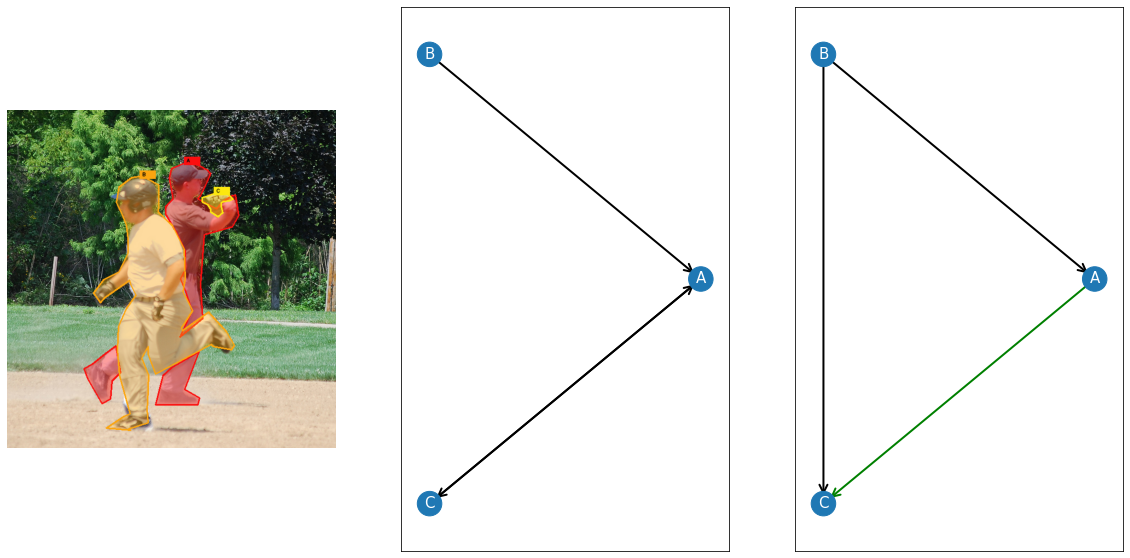

InstaOrder Annotation: {'image_id': 872, 'instance_ids': [559508, 560228, 633972], 'occlusion': [{'order': '0<2 & 2<0', 'count': 3}, {'order': '1<0', 'count': 2}], 'depth': [{'order': '1<2', 'count': 2, 'overlap': False}, {'order': '1<0', 'count': 2, 'overlap': False}, {'order': '0<2', 'count': 2, 'overlap': True}]}


In [6]:
# choose image & read anns
img_num = 0
InstaOrder_ann = InstaOrder_data['annotations'][img_num]

plt.cla()
annIds = InstaOrder_ann['instance_ids']
coco_data = coco.loadImgs(int(InstaOrder_ann['image_id']))[0]
image_h, image_w = coco_data['height'], coco_data['width']

# read instance annotations
img = io.imread(f"{base_dir}/{dataType}/{coco_data['file_name']}")
annIds = [int(annId) for annId in InstaOrder_ann['instance_ids']]
anns = coco.loadAnns(annIds)
num_inst = len(annIds)

# 1. draw instances masks on the image
plt.subplot(131)
plt.axis("off")   
img_w_inst = draw_instance_mask(img, anns)
plt.imshow(img_w_inst)

# 2. draw occlusion graph
plt.subplot(132)
draw_occ_graph(InstaOrder_ann['occlusion'], num_inst)

# 3. draw depth graph
plt.subplot(133)    
draw_depth_graph(InstaOrder_ann['depth'], num_inst)

plt.savefig(f"{folder2save}/{coco_data['id']}.png")
plt.show()
print("InstaOrder Annotation:", InstaOrder_ann)
